# <center> Trabalho Final - Aprendizado de Máquina </center>

**Aluno(a):** Marianna de Pinho Severo <br>
**Matrícula:** 374856 <br>
**Professor(a):** Regis Pires

## 1) Problema a ser resolvido

### Descrição
O problema a ser resolvido consiste na identificação de doenças respiratórios em pessoas
através da análise de áudios que registram sua respiração. De acordo com [Respiratory Sound Database](https://www.kaggle.com/vbookshelf/respiratory-sound-database), o som que é
emitido quando uma pessoa respira está diretamente relacionado com o movimento do ar,
as condições do tecido pulmonar e a existência ou não de secreções dentro do pulmão.

Vamos utilizar o dataset para um problema de classificação, que consiste em, dado um
conjunto de áudios que capturam a respiração de um certo indivíduo, determinar se ele
possui, ou não, uma das doenças respiratórias cobertas pelo dataset. Mais especificamente, diremos se um paciente é saudável ou se possui alguma doença respiratória.

### Datasets a serem utilizados
Utilizaremos o dataset criado para a International Conference on Biomedical
Health Informatics - ICBHI 2017, disponível em [Respiratory Sound Database](https://www.kaggle.com/vbookshelf/respiratory-sound-database). Ele foi criado por duas equipes, sendo
uma de Portugal e outra da Grécia. Esse dataset inclui 920 anotações de áudios, de
tamanhos variáveis entre 10s e 90s. Essas gravações foram obtidas a partir de 126
pacientes diferentes, contendo 6898 ciclos respiratórios, dos quais 1864 contêm
crepitações, 886 contêm chiados e 506 contêm tanto crepitações quanto chiados. Além disso,
o dataset é composto tanto por áudios limpos como por áudios com ruídos. E existem
pacientes de todas as faixas etárias: crianças, adultos e idosos.

### Features
#### a) Pacientes:
**Dados demográficos:** número do paciente, idade, sexo, IMC do adulto
(kg/m2), peso da criança (kg), altura da criança (cm).

#### b) Áudios:
**numero do paciente**<br>
**Índice de gravação**<br>
**Localização no peito:** trachea (Tc), anterior left (Al), anterior right (Ar),
posterior left (Pl), posterior right (Pr), lateral left (Ll), lateral right (Lr).<br>
**Modo de aquisição:** sequential/single channel (sc),
simultaneous/multichannel (mc).<br>
**Equipamento de gravação:** AKG C417L Microphone (AKGC417L), 3M
Littmann Classic II SE Stethoscope (LittC2SE), 3M Litmmann 3200 Electronic
Stethoscope (Litt3200), WelchAllyn Meditron Master Elite Electronic
Stethoscope (Meditron).

#### c) Anotações:
Início do ciclo respiratório(s), Fim do ciclo respiratório(s), Presença/Ausência
de crepitações (presence=1, absence=0), Presença/Ausência de sibilos
(presence=1, absence=0).

## 2) Importando bibliotecas

In [36]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from python_speech_features import mfcc, logfbank
import soundfile as sf

## 3) Funções de plotagem auxiliares

Funções retiradas de [Audio-Classification](https://github.com/seth814/Audio-Classification/blob/master/eda.py).

In [2]:
def plot_signals(signals):
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Time Series', size=16)
    i = 0
    for x in range(2):
        for y in range(5):
            axes[x,y].set_title(list(signals.keys())[i])
            axes[x,y].plot(list(signals.values())[i])
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1

In [3]:
def plot_fft(fft):
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Fourier Transforms', size=16)
    i = 0
    for x in range(2):
        for y in range(5):
            data = list(fft.values())[i]
            Y, freq = data[0], data[1]
            axes[x,y].set_title(list(fft.keys())[i])
            axes[x,y].plot(freq, Y)
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1

In [4]:
def plot_fbank(fbank):
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Filter Bank Coefficients', size=16)
    i = 0
    for x in range(2):
        for y in range(5):
            axes[x,y].set_title(list(fbank.keys())[i])
            axes[x,y].imshow(list(fbank.values())[i],
                    cmap='hot', interpolation='nearest')
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1

In [5]:
def plot_mfccs(mfccs):
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Mel Frequency Cepstrum Coefficients', size=16)
    i = 0
    for x in range(2):
        for y in range(5):
            axes[x,y].set_title(list(mfccs.keys())[i])
            axes[x,y].imshow(list(mfccs.values())[i],
                    cmap='hot', interpolation='nearest')
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1

## 4) Observando datasets

In [39]:
PATH = 'respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/'
filenames = [s.split('.')[0] for s in os.listdir(path = PATH) if '.txt' in s]
filenames[:5]

['198_6p1_Lr_mc_AKGC417L',
 '130_3p2_Ar_mc_AKGC417L',
 '215_1b3_Tc_sc_Meditron',
 '176_1b3_Ll_mc_AKGC417L',
 '172_1b4_Ll_mc_AKGC417L']

Os nomes dos arquivos de áudio são compostos pelo número do paciente, índice de gravação, localização do microfone no peito do paciente, modo de aquisição do áudio e equipamento de gravação. Essas informações podem ser vistas em **filenames**.

### 4.1 - Lendo conjunto de dados demográficos

In [23]:
cols = ['patient_number', 'age', 'sex' , 'adult_BMI', 'child_weight' , 'child_height']
demographic_data = pd.read_csv('dataset/demographic_info.txt', names=cols, sep=' ')
demographic_data.head()

,patient_number,age,sex,adult_BMI,child_weight,child_height
0,101,3.00,F,NaN,19.0,99.0
1,102,0.75,F,NaN,9.8,73.0
2,103,70.00,F,33.00,NaN,NaN
3,104,70.00,F,28.47,NaN,NaN
4,105,7.00,F,NaN,32.0,135.0


### 4.2 - Lendo conjunto de dados de diagnóstico

In [8]:
cols = ['patient_number', 'diagnosis']
diagnosis_data = pd.read_csv('dataset/patient_diagnosis.csv', names=cols)
diagnosis_data.head()

,patient_number,diagnosis
0,101,URTI
1,102,Healthy
2,103,Asthma
3,104,COPD
4,105,URTI


### 4.3 - Lendo conjunto de dados de anotações

In [35]:
anotations_list = []

for f in filenames:
    df = pd.read_csv(os.path.join(PATH, f + '.txt'), names = ['Start', 'End', 'Crackles', 'Wheezes'], delimiter= '\t')
    df.insert(0, 'patient_number',f.split('_')[0])
    anotations_list.append(df)

anotations_dataset = pd.concat(anotations_list, axis=0)
anotations_dataset.head(10)

,patient_number,Start,End,Crackles,Wheezes
0,198,0.042,1.243,1,0
1,198,1.243,4.049,1,0
2,198,4.049,6.940,1,0
3,198,6.940,10.254,1,0
4,198,10.254,13.466,1,0
5,198,13.466,16.948,1,0
6,198,16.948,19.535,1,0
0,130,1.461,2.918,0,0
1,130,2.918,5.839,1,0
2,130,5.839,8.605,0,0


## 5) Observando distribuição de classes

In [9]:
classes = pd.read_csv('dataset/patient_diagnosis.csv', names = ['patient_number','diagnosis'])

In [10]:
classes_dist = classes['diagnosis'].value_counts()

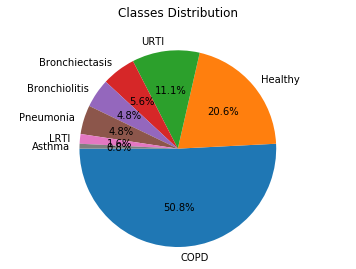

In [11]:
fig, ax = plt.subplots()
ax.set_title('Classes Distribution', y=1.08)
ax.pie(classes_dist, labels=classes_dist.index, autopct='%1.1f%%', shadow=False, startangle=180)
ax.axis('equal')
plt.show()

Com esse gráfico em pizza, podemos observar a distribuição das classes do nosso conjunto de dados. Conforme podemos ver, 20.6% das amostras do conjunto de dados são de pacientes considerados saudáveis.

## 6) Lendo arquivos de áudio

In [13]:
def getAudioInfo(audio):
    signal, rate = sf.read(audio)
    duration = [signal.shape[0]/rate]
    return signal, rate, duration

In [14]:
dict_audio_signals = {}
dict_audio_rates = {}
dict_audio_durations = {}

In [15]:
i = 0
for f in filenames:
    if(i == 10):
        break
    i+=1
    dict_audio_signals[f], dict_audio_rates[f], dict_audio_durations[f] = getAudioInfo(PATH + f + '.wav')

Em **dict_audio_signals** guardamos os dados de cada arquivo de áudio, ou seja, os valores que representam o formato de onda dos sons gravados. Em **dict_audio_rates** guardamos as taxas de amostragem, ou seja, as quantidades de amostras por segundo utilizadas para a captura dos sons. Por fim, em **dict_audio_durations** guardamos a duração de cada áudio, em segundos.

## 7) Visualizando audios

Um dos passos mais importantes quando queremos aplicar algoritmos de aprendizado de máquina em sinais de áudio é a extração de características, a partir desses sinais, que possam ser eficazmente utilizadas para identificarmos cada áudio.

Uma das técnicas mais utilizadas para a análise de sinais é a Transformada de Fourier, que nos permite identificar as frequências existentes em um sinal. Quando falamos de áudio, devemos nos atentar ao modo como o ouvido humano funciona. Nós temos uma pequena capacidade de diferenciar frequências muito próximas e essa capacidade diminui conforme aumentamos essas frequências. Dessa forma, uma maneira de extrair características de áudios de forma que elas se aproximem da forma como os seres humanos escutam é utilizando o que chamamos de Mel Frequency Cepstrum Coefficients. Uma explicação mais detalhada de como isso funciona pode ser encontrada em [Mel Frequency Cepstral Coefficient (MFCC) tutorial](http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/#eqn2).

In [16]:
signals = {}
fft = {}
fbank = {}
mfccs = {}

In [17]:
def calc_fft(y, rate):
    n = len(y)
    freq = np.fft.rfftfreq(n, d=1/rate)
    y_mag = abs(np.fft.rfft(y)/n)
    return (y_mag, freq)

### 7.1 - Extraindo características do áudio

In [18]:
i = 0
for key in dict_audio_signals:
    if(i == 10):
        break
    i+=1
    
    signal, rate = dict_audio_signals[key], dict_audio_rates[key]
    signals[key] = signal
    fft[key] = calc_fft(signal, rate)
    
    #signal[:rate] means 1 second of signal
    bank = logfbank(signal[:rate], rate, nfilt=26, nfft=1103).T
    fbank[key] = bank
    mel = mfcc(signal[:rate], rate, numcep=13, nfilt=26, nfft=1103).T
    mfccs[key] = mel

### 7.2 - Visualizando sinais no domínio do tempo (Série Temporal)

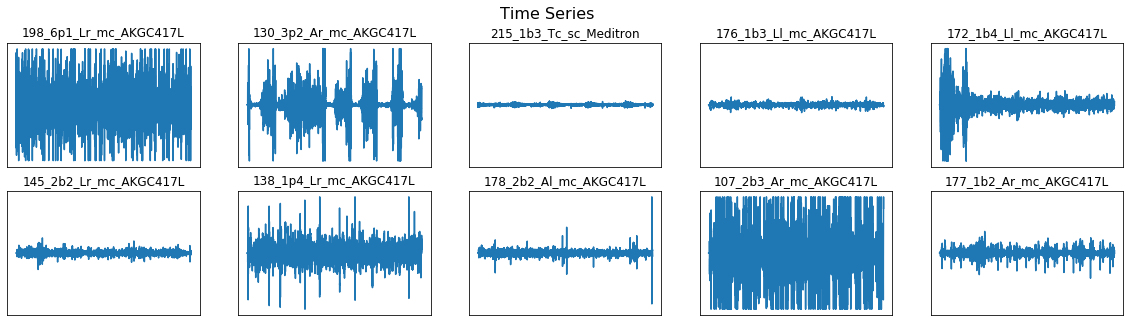

In [19]:
plot_signals(signals)
plt.show()

### 7.3 - Visualizando sinais no domínio da frequência (Tranformada de Fourier)

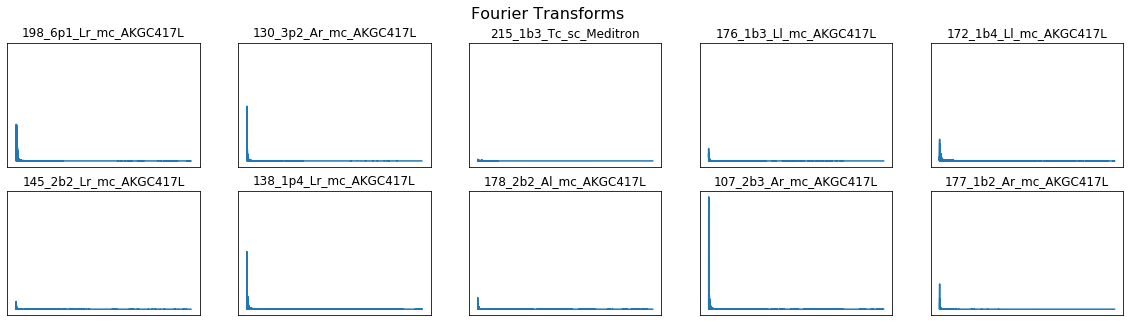

In [20]:
plot_fft(fft)
plt.show()

### 7.4 - Visualizando espectograma com todos os bancos de frequências

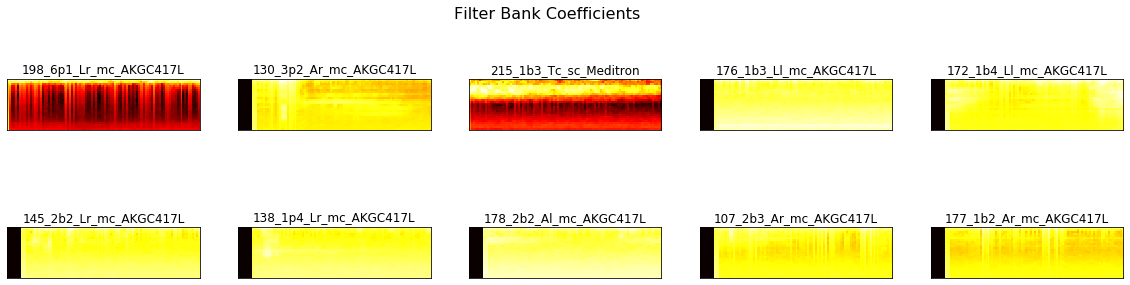

In [21]:
plot_fbank(fbank)
plt.show()

### 7.5 - Visualizando Mel Frequency Cepstrum Coefficients

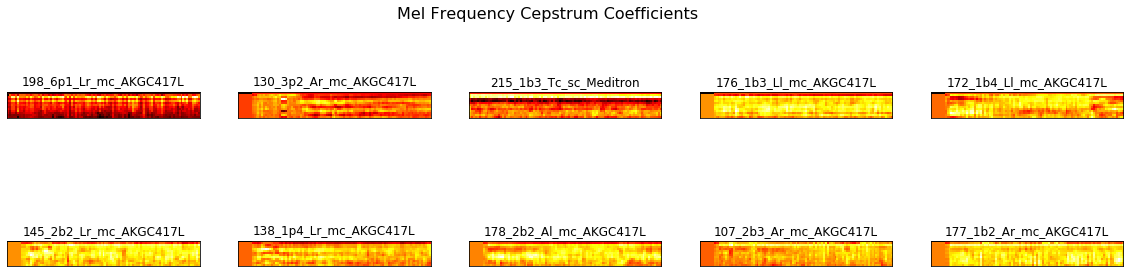

In [22]:
plot_mfccs(mfccs)
plt.show()